# Visualizing the Pix2Pix results


In [ ]:
import os
import numpy as np
import tensorflow as tf
import sys

import cv2
from skimage import io
from skimage import feature

import matplotlib
import matplotlib.pyplot as plt

import random #for random number


In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/')  # 'My Drive' is the default name of Google Drives
    os.chdir('drive/My Drive/dmlap-final') # change to your favourite dir

Mounted at /content/drive/


# download videos from youtube using yt-dlp

In [ ]:
!pip install yt-dlp

In [ ]:
#see all options
!yt-dlp -h

In [ ]:
!yt-dlp -S ext:mp4:m4a 95j9g1jg7Ls -o /content/drive/MyDrive/dmlap-final/Vids/source/o.mp4

ffmpeg

In [ ]:
!apt install ffmpeg # install ffmpeg


In [ ]:
# convert
!ffmpeg -i "/content/Screen Recording 2024-01-08 at 10.33.19.mov" -c:v libx264 -c:a aac "/content/me.mp4"

In [ ]:
# resize
!ffmpeg -i "/content/me.mp4" -vf "scale=256:-1,pad=256:256:(ow-iw)/2:(oh-ih)/2" -c:a copy "/content/drive/MyDrive/dmlap-final/Vids/source/me.mp4"

In [ ]:
# get frames
!ffmpeg -ss 00:00:00 -i "/content/drive/MyDrive/dmlap-final/Vids/source/speech256.mp4" -vf "fps=16" "/content/drive/MyDrive/dmlap-final/Vids/frames/imm_in/frame_%04d.png"

## Utils

In [ ]:
!pip install mediapipe==0.10.5

In [ ]:
import mediapipe as mp
from mediapipe import solutions
def apply_face_landmarks(img, stroke_weight=2):
    # Convert the image to RGB
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Face Landmarker
    mp_face_mesh = solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

    # Process the image and draw landmarks
    results = face_mesh.process(rgb_image)

    # Create a black image of the same size
    black_image = np.zeros_like(rgb_image)

    # Define white color for landmarks
    white_color = (255, 255, 255)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image=black_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=solutions.drawing_utils.DrawingSpec(color=(255, 255, 255)))

    return cv2.cvtColor(black_image, cv2.COLOR_RGB2BGR)


---

## Landmarks to faces

First let's load the generator.
- `model_path`: directory where you saved your models.
- `epoch`: which epoch to load (it's actually steps not epochs)

In [ ]:
model_path = '/content/drive/MyDrive/dmlap-final/model-pix2pix/ganface_mediapipe'
epoch = 420000

generator = tf.keras.models.load_model(
    os.path.join(model_path, f'e{epoch}_generator.hd5')
)

convert to tensorflowjs ( i didn't end up using this but may be useful in the future

In [ ]:
!pip install tensorflowjs

In [ ]:
!pip uninstall jax jaxlib -y

In [ ]:
!pip install jax==0.4.21 jaxlib==0.4.21

In [ ]:
!tensorflowjs_converter --input_format keras /content/drive/MyDrive/dmlap-final/model-pix2pix/ganface_mediapipe/e360000_generator.hd5 /content/drive/MyDrive/dmlap-final/model-pix2pix/js-conversion/ganface-mediapipe

for testing purpose, run below 2 cells to resize image found online and put it through the model

In [ ]:
from PIL import Image

# Load the image
image_path = '/content/download (3).jpeg'
img = Image.open(image_path)

# resize the image
img_resized = img.resize((256, 256))

# save the resized image
img_resized.save('/content/re.png')

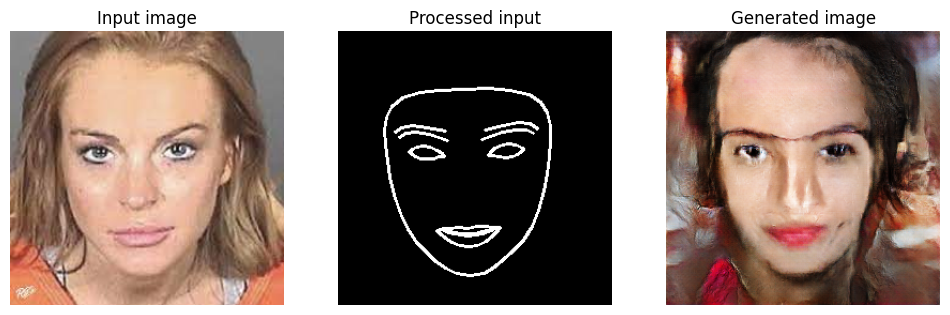

In [ ]:
img = io.imread('/content/re.png')
landmark_img = apply_face_landmarks(img)

plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.title('Input image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Processed input')
plt.imshow(landmark_img)
plt.axis('off')
plt.subplot(1, 3, 3)
gen_img = transform_image(landmark_img)
plt.title('Generated image')
plt.imshow(gen_img)
plt.axis('off')
plt.show()

In [ ]:
input_folder = '/content/drive/MyDrive/dmlap-final/Vids/frames/imm_in'
output_folder = '/content/drive/MyDrive/dmlap-final/Vids/frames/imm_out'

def process_frames(input_folder, output_folder, start_frame=1, end_frame=None):
    counter = start_frame
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith('.png'):
            if counter >= start_frame and (end_frame is None or counter <= end_frame):
                img_path = os.path.join(input_folder, filename)
                img = io.imread(img_path)

                # apply face landmarks (or other transformations)
                edges_img = apply_face_landmarks(img)

                # transform image
                gen_img = transform_image(edges_img)

                # format output filename with number
                output_filename = f'frame_{counter:04d}.png'
                output_path = os.path.join(output_folder, output_filename)

                # save the generated image
                plt.imsave(output_path, gen_img)

            counter += 1  # Increment the counter

#determine the total number of frames
total_frames = len([name for name in os.listdir(input_folder) if name.endswith('.png')])

#process the first half of the frames
# process_frames(input_folder, output_folder, start_frame=1, end_frame=total_frames // 2)

#after restarting the runtime, process the second half
process_frames(input_folder, output_folder, start_frame=(total_frames // 2) + 1, end_frame=total_frames)



---

## ffmpeg to compose the frames
frames to video + sound from original video

In [ ]:
!ffmpeg -framerate 16 -i "/content/drive/MyDrive/dmlap-final/Vids/frames/imm_out/frame_%04d.png" -i "/content/drive/MyDrive/dmlap-final/Vids/source/speech256.mp4" -c:v libx264 -pix_fmt yuv420p -map 0:v -map 1:a -shortest "/content/drive/MyDrive/dmlap-final/Vids/immigration-fin.mp4"